In [1]:
pwd

'/Users/zofia/github/DFM/interactivePython'

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import integrator
import sampler #as sampler
import model #as model
import diffusionmap as dm
import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
from openmmtools.constants import kB

import model
mdl=model.Model('Dimer')
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
print (mdl.testsystem.positions)
X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)
print('Initial distance is %f' % np.linalg.norm(X0[0,:]-X0[ 1,:]))

algoVect=0

# parameters
# this is the target temperature 
T=100.0
temperature =  T * unit.kelvin#300 * unit.kelvin
kT = kB * temperature


gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

TemperatureTAMDFactor=30.0
massScale=50.0

gammaScale=100.0
kappaScale=1000.0

print("TemperatureTAMDFactor = " + repr(TemperatureTAMDFactor))
temperatureAlpha= (T*TemperatureTAMDFactor)* unit.kelvin

print('Gamma is '+repr(gamma))
print('Temperature is '+repr(temperature))
print('Temperature TAMD '+repr(TemperatureTAMDFactor)+'xTemperature')
print('Mass alpha is '+repr(massScale)+'x Mass')



# simulation class sampler takes integrator class with chosen parameters as input
integrator=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, temperatureAlpha=temperatureAlpha, dt=dt, massScale=massScale, gammaScale=gammaScale, kappaScale=kappaScale)
samplerAlgo=sampler.Sampler(model=mdl, integrator=integrator, algorithm=0, dataFileName='Data')

# nrSteps is number of steps for each nrRep , and iterate the algo nrIterations times - total simulation time is nrSteps x nrIterations
# nrSteps=args.nrSteps
# nrEquilSteps = 10 #10000
# nrIterations=args.niterations
# nrRep=args.nreplicas

algoNames=samplerAlgo.algorithmName



Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=2.55, unit=angstrom)
angstrom
System has 2 particle(s)
[[ 0.          0.          0.        ]
 [ 1.54999995  0.          0.        ]] A
Initial distance is 1.550000
TemperatureTAMDFactor = 30.0
Gamma is Quantity(value=1.0, unit=/picosecond)
Temperature is Quantity(value=100.0, unit=kelvin)
Temperature TAMD 30.0xTemperature
Mass alpha is 50.0x Mass
59.4214417593 K


In [20]:
colorList=['red', 'blue', 'black', 'green']
    
# copy values for the two states from above
min1=1.55*model.unit.angstroms
min2=2.55*model.unit.angstroms


In [24]:
#---------------- load trajectories: for example from simulation at higher temperature
import glob
numpy_vars = []
for np_name in glob.glob('/Users/zofia/github/DFM/Data/Std/Traj/T500/*.h5'):
    numpy_vars.append(md.load(np_name))

traj = numpy_vars
print(len(traj))


import mdtraj as md
Xmdtraj=list()
for i in range(len(traj)):
    Xmdtraj.append(md.Trajectory(traj[i].xyz, mdl.testsystem.topology) )

print(Xmdtraj[0].xyz.shape[2])
L=int(Xmdtraj[0].xyz.shape[0]*len(traj))
nrP=int(Xmdtraj[0].xyz.shape[1])
D=int(Xmdtraj[0].xyz.shape[2])
X=np.zeros((L, nrP, D))
for i in range(0,len(Xmdtraj)):
        X[i*len(Xmdtraj[i].xyz):(i+1)*len(Xmdtraj[i].xyz),:,:]=Xmdtraj[i].xyz

Xref=X


10
3


3
(10000, 2, 3)
(10000,)


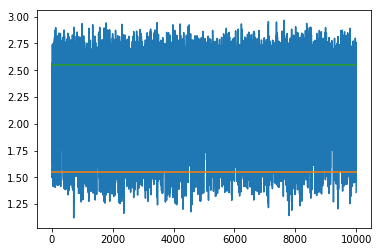

Initial radius: 1.5793917856218731
Mean radius: 2.2592965831818765


In [25]:

import mdtraj as md
Xmdtraj=list()
for i in range(len(traj)):
    Xmdtraj.append(md.Trajectory(traj[i].xyz, mdl.testsystem.topology) )

print(Xmdtraj[0].xyz.shape[2])
L=int(Xmdtraj[0].xyz.shape[0]*len(traj))
nrP=int(Xmdtraj[0].xyz.shape[1])
D=int(Xmdtraj[0].xyz.shape[2])
X=np.zeros((L, nrP, D))
for i in range(0,len(Xmdtraj)):
        X[i*len(Xmdtraj[i].xyz):(i+1)*len(Xmdtraj[i].xyz),:,:]=Xmdtraj[i].xyz

print(X.shape)

#---------------- radius 
r=np.linalg.norm(X[:,0,:]-X[:,1,:], 2, axis=1)
print(r.shape)

plt.plot(range(len(r)), r)
plt.plot(range(len(r)), np.ones(len(r))*min1)
plt.plot(range(len(r)), np.ones(len(r))*min2)
plt.show()

print("Initial radius: "+repr(np.linalg.norm(X[0, 0,:]-X[0, 1,:])))
print("Mean radius: " +repr(np.mean(r)))


In [26]:
#---------- VISUALISATION OF THE MOLECULE
#align according to first frame
traj[0]=traj[0].superpose(traj[0][0])
tpl=traj[0].topology
print(tpl)
import nglview as nv
view = nv.show_mdtraj(traj[0])

view.add_representation('spacefill', selection='all' )
view.frame = 10
view

#--- saving as gif: does not work :(
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(view, output='my.gif')
# movie.make()


<mdtraj.Topology with 1 chains, 1 residues, 2 atoms, 0 bonds>


A Jupyter Widget

In [27]:
import imp
imp.reload(sampler)
imp.reload(dm)
imp.reload(stat)

def FE(tr, eps, numberOfLandmarks, smpl, model, T, method): 
        
        tr_orig=tr
        
        tmp=md.Trajectory(tr, model.testsystem.topology)
        tmp.superpose(tmp[0])
        #------ reshape data ------------------------------

        tmp =  tmp.xyz.reshape((tmp.xyz.shape[0], tmp.xyz.shape[1]*tmp.xyz.shape[2]))
                
        tr=tmp
        v1, qTarget, qEmp, Epot, kernel=sampler.dominantEigenvectorDiffusionMap(tr, eps, smpl, T, method)
        
        #qTargetNormalized = qTarget/np.sum(qTarget)
        
        #get landmarks
        lm, levelsets, linspV = dm.get_landmarks(tr, numberOfLandmarks, qTarget, v1, Epot, getLevelSets=True)
        
        levelsets, levels = dm.get_levelsets(tr, numberOfLandmarks, qTarget, v1);
        
      
        
        tr =  tr.reshape((tr_orig.shape[0], tr_orig.shape[1],tr_orig.shape[2]))
        
        return tr, levelsets, v1, lm, qEmp, Epot


def computeFreeEnergyAtLandmarkedPoint(qTarget, qEmp, levelsets, method='weighted'):
      
        if(method=='weighted'):
            weight, Ntilde = stat.compute_weight_target_distribution(qTarget, qEmp)
        
        
        K=len(levelsets)
        
        freeEnergy=np.zeros(K)
        h=np.zeros(K)

        for k in range(0,K):
            # simple histogram
            if(method == 'unweighted'):
                h[k] = np.sum(len(levelsets[k]))
            elif(method=='weighted'):
#              # unbiased histogram- we can use weights!!
                h[k] = np.sum(weight[levelsets[k]])
            
        for k in range(0,K):
            if(h[k] == 0):
                freeEnergy[k] = 0 # if the bin is empty set 0
            else:
                if(method == 'unweighted'):
                    freeEnergy[k] = -np.log(h[k]/sum(h))
                elif(method=='weighted'):
#              
                    freeEnergy[k] = -np.log(h[k]/sum(h) / Ntilde)
                
        
                
        if(method=='weighted'):
            return freeEnergy, weight, Ntilde
        else:
            return freeEnergy



Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=2.55, unit=angstrom)


In [28]:
numberOfLandmarks=10
epsilon=1

Xshort=X
while(len(Xshort)>999):
    Xshort=Xshort[::2]
#Xshort=X[::10]
print("Shape of input data: "+repr((Xshort.shape)))

# note that samplerAlgo.T gives the target temperature from the at the beginning initialized class
print("Target temperature is "+repr(samplerAlgo.T))

Xsp,levelsets, V1, lm, qEmp, Epot =FE(Xshort, epsilon, numberOfLandmarks, samplerAlgo, samplerAlgo.model, samplerAlgo.T, 'TMDiffmap')#'TMDiffmap')#'Diffmap')



Shape of input data: (625, 2, 3)
Target temperature is Quantity(value=100.0, unit=kelvin)
constructing neighbor graph
neighbor graph done


In [29]:
qTarget=np.exp(-Epot/samplerAlgo.T)

freeEnergyWeighted, weight, Ntilde= computeFreeEnergyAtLandmarkedPoint(qTarget, qEmp, levelsets, method='weighted')
freeEnergyUnWeighted= computeFreeEnergyAtLandmarkedPoint(qTarget, qEmp, levelsets, method='unweighted')


r=np.linalg.norm(Xsp[:,0,:]-Xsp[:,1,:], 2, axis=1)



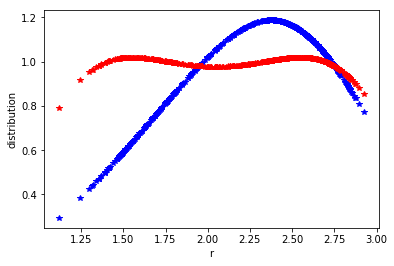

In [30]:
qTarget=np.exp(-Epot/samplerAlgo.T)
plt.plot(r, qEmp/np.mean(qEmp), '*b')
plt.plot(r, qTarget/np.mean(qTarget), '*r')
plt.xlabel('r')
plt.ylabel('distribution')
plt.show()

In [31]:
def plotResults(freeEnergyUnWeighted, freeEnergyWeighted, V1, lm, Epot, r):
    print(freeEnergyUnWeighted)
    freeEnergy=freeEnergyUnWeighted
    #plt.scatter(v1TMDiffmap, Epot)
    plt.plot(V1[lm], freeEnergy, '*-b')
    plt.xlabel('V1')
    plt.ylabel('Free energy ln(pi(V1(x)))')
    plt.show()

    plt.plot(r[lm], freeEnergyWeighted, '*-b')
    plt.plot(r[lm], freeEnergyUnWeighted, '*-r')
    plt.xlabel('r')
    plt.ylabel('Free energy ln(pi(V1(x)))')
    plt.show()


    plt.scatter(  V1, Epot)
    plt.plot( V1[lm],Epot[lm], '*-r')
    plt.xlabel('V1')
    plt.ylabel('potential energy')
    plt.show()

    plt.scatter(  r, Epot, c=V1)
    plt.plot(  r[lm], Epot[lm], '-*r')
    plt.xlabel('r')
    plt.ylabel('potential energy')
    plt.show()

    plt.scatter(  r, V1)
    plt.plot(  r[lm], V1[lm], '*-r')
    plt.xlabel('r')
    plt.ylabel('V1')
    plt.show()

[ 1.79865605  1.5118394   1.64203684  2.46787046  3.01073544  2.86996289
  2.69439811  2.50223811  2.90073454  3.6808931 ]


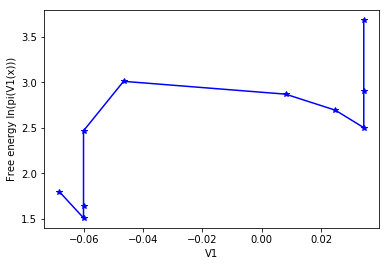

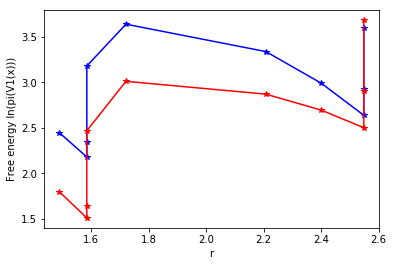

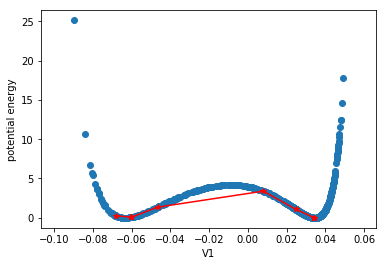

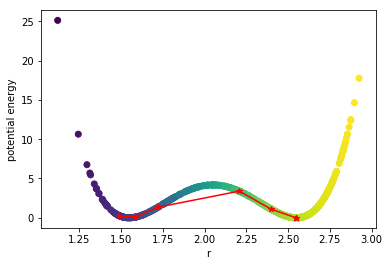

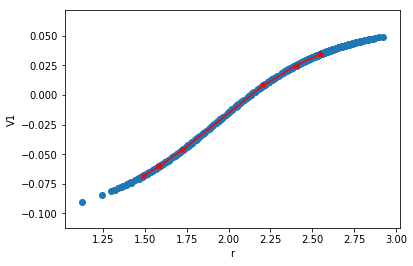

In [32]:
plotResults(freeEnergyUnWeighted, freeEnergyWeighted, V1, lm, Epot, r)

In [33]:
# Xmd = md.Trajectory(Xshort,  mdl.testsystem.topology)

# rmsd = md.rmsd(Xmd, Xmd[0])
# print(rmsd[0])

# plt.plot(rmsd[lm], freeEnergy, '*-b')
# #plt.plot(rmsd, r, '*b')
# plt.xlabel('rmsd')
# plt.ylabel('r')
# plt.show()

# Averages

In [34]:
imp.reload(stat)
#print(samplerAlgo.model.energy)
#print(weight)
print('mean weight is '+repr(np.mean(weight)))

#-----------average energy
meanV = stat.computeAverages(Xshort, samplerAlgo.model.energy, units=samplerAlgo.model.energy_unit)
meanVunbiased = stat.computeUnbiasedAverages(Xshort, samplerAlgo.model.energy, weight, units=samplerAlgo.model.energy_unit)

print('Raw:')
print('<V> = '+repr(meanV*samplerAlgo.model.energy_unit))

print('\nUnbiased:')
print('<V> = '+repr(meanVunbiased*samplerAlgo.model.energy_unit))


#---------- average radius
def compute_radius_2_particles(X):
    return np.linalg.norm(X[0,:]-X[1,:], 2)
    
meanR = stat.computeAverages(Xshort, compute_radius_2_particles)
meanRunbiased = stat.computeUnbiasedAverages(Xshort, compute_radius_2_particles, weight)

print('\nExpected mean radius (state1+state2)/2 = '+repr(0.5*(min1+min2)))

print('Raw:')
print('<radius> = '+repr(meanR*samplerAlgo.model.x_unit))

print('\nUnbiased:')
print('<radius> = '+repr(meanRunbiased*samplerAlgo.model.x_unit))


mean weight is 0.0026596540146289621
Raw:
<V> = Quantity(value=14430454.457350001, unit=kilojoule/mole)

Unbiased:
<V> = Quantity(value=12804621.252827514, unit=kilojoule/mole)

Expected mean radius (state1+state2)/2 = Quantity(value=2.05, unit=angstrom)
Raw:
<radius> = Quantity(value=2.2463679472065348, unit=angstrom)

Unbiased:
<radius> = Quantity(value=2.1456897823875329, unit=angstrom)


10
3
(10000,)


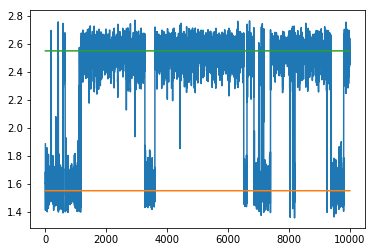

Initial radius: 1.8849581756761868
Mean radius: 2.3029574583536911


In [35]:
#---------------- load reference data - at lower temperature 
import glob
numpy_vars = []
for np_name in glob.glob('/Users/zofia/github/DFM/Data/Std/Traj/T100/*.h5'):
    numpy_vars.append(md.load(np_name))

traj = numpy_vars
print(len(traj))


import mdtraj as md
Xmdtraj=list()
for i in range(len(traj)):
    Xmdtraj.append(md.Trajectory(traj[i].xyz, mdl.testsystem.topology) )

print(Xmdtraj[0].xyz.shape[2])
L=int(Xmdtraj[0].xyz.shape[0]*len(traj))
nrP=int(Xmdtraj[0].xyz.shape[1])
D=int(Xmdtraj[0].xyz.shape[2])
X=np.zeros((L, nrP, D))
for i in range(0,len(Xmdtraj)):
        X[i*len(Xmdtraj[i].xyz):(i+1)*len(Xmdtraj[i].xyz),:,:]=Xmdtraj[i].xyz

Xref=X



#---------------- radius 
r=np.linalg.norm(X[:,0,:]-X[:,1,:], 2, axis=1)
print(r.shape)

plt.plot(range(len(r)), r)
plt.plot(range(len(r)), np.ones(len(r))*min1)
plt.plot(range(len(r)), np.ones(len(r))*min2)
plt.show()

print("Initial radius: "+repr(np.linalg.norm(X[0, 0,:]-X[0, 1,:])))
print("Mean radius: " +repr(np.mean(r)))


#compute_weight_target_distribution(target_distribution, qImoportanceSampling)

In [36]:

Xshortref=Xref
while(len(Xshortref)>999):
    Xshortref=Xshortref[::2]
#Xshort=X[::10]
print("Shape of input data: "+repr((Xshortref.shape)))



Xspref,levelsetsref, V1ref, lmref, qEmpref, Epotref =FE(Xshortref, epsilon, numberOfLandmarks, samplerAlgo, samplerAlgo.model, samplerAlgo.T, 'TMDiffmap')#'TMDiffmap')#'Diffmap')




Shape of input data: (625, 2, 3)
constructing neighbor graph
neighbor graph done


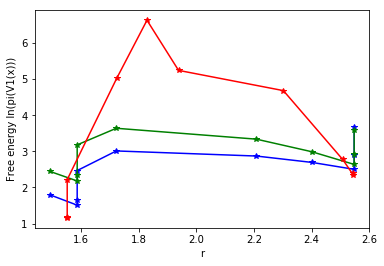

In [37]:

qTargetref=np.exp(-Epotref/samplerAlgo.T)
freeEnergyWeightedref, weightref, Ntilderef= computeFreeEnergyAtLandmarkedPoint(qTargetref, qEmpref, levelsetsref, method='weighted')
freeEnergyUnWeightedref= computeFreeEnergyAtLandmarkedPoint(qTargetref, qEmpref, levelsetsref, method='unweighted')

r=np.linalg.norm(Xshort[:,0,:]-Xshort[:,1,:], 2, axis=1)
rref=np.linalg.norm(Xshortref[:,0,:]-Xshortref[:,1,:], 2, axis=1)

freeEnergy=freeEnergyUnWeighted
freeEnergyref=freeEnergyUnWeightedref

plt.plot(r[lm], freeEnergy, '*-b')
plt.plot(r[lm], freeEnergyWeighted, '*-g')
plt.plot(rref[lmref], freeEnergyref, '*-r')
plt.xlabel('r')
plt.ylabel('Free energy ln(pi(V1(x)))')
plt.show()


[ 2.40522131  2.35503157  2.77458142  4.67881887  5.23843466  6.62472902
  5.01529111  2.21800977  1.15878081  1.18014914]


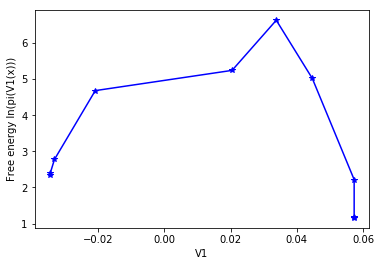

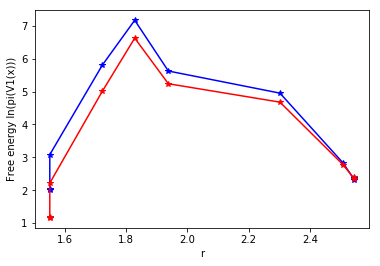

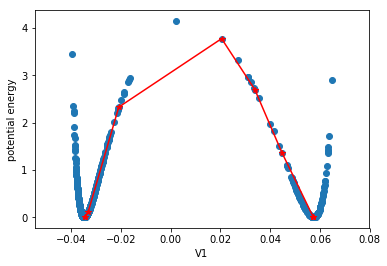

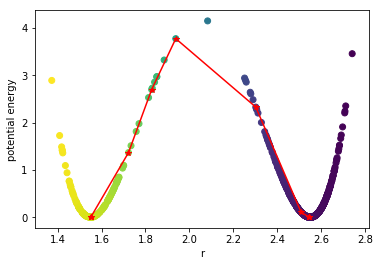

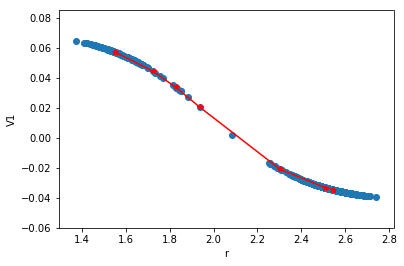

In [38]:
plotResults(freeEnergyUnWeightedref, freeEnergyWeightedref, V1ref, lmref, Epotref, rref)